In [1]:
# Import all the libraries needed
import pandas as pd    # to load dataset
import numpy as np     # for mathematical equations
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split    # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense   # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import matplotlib.pyplot as plt   # to plot the models
import re

In [2]:
# Preview train dataset 
data = pd.read_csv('phm_train.csv')
print(data)

          tweet_id  label                                              tweet
0     6.430000e+17      0  user_mention all i can tell you is i have had ...
1     6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2     8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3     6.820000e+17      0  i got xans in an advil bottle i dont take them...
4     6.440000e+17      1  mom says i need to stop eating so much bc ive ...
...            ...    ...                                                ...
9986  6.480000e+17      1                          that vicodin messed me up
9987  5.710000e+17      0                  user_mention get some tylenol lol
9988  6.470000e+17      0                          like a walking tamiflu ad
9989  6.990000e+17      0                         klay and steph on steroids
9990  8.230000e+17      0                    horrible pops another xanax url

[9991 rows x 3 columns]


In [3]:
# Declaring the english stop words
english_stops = set(stopwords.words('english'))

In [4]:
# Preprocessing and Encoding labels
def load_dataset(dataset):
    x_data = dataset['tweet']       # Tweet/Input
    y_data = dataset['label']    # Label/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'_': ' '}, regex = True)  
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    return x_data, y_data

In [100]:
x_data, y_data = load_dataset(data)
print('Tweet')
print(x_data, '\n')
print('Label')
print(y_data)

Tweet
0       [user, mention, tell, relapses, cure, hear, do...
1       [doctor, told, stop, gave, sum, pop, mix, w, a...
2       [take, tylenol, wake, middle, night, put, ice,...
3       [got, xans, advil, bottle, dont, take, shits, ...
4       [mom, says, need, stop, eating, much, bc, ive,...
                              ...                        
9986                                    [vicodin, messed]
9987                   [user, mention, get, tylenol, lol]
9988                         [like, walking, tamiflu, ad]
9989                              [klay, steph, steroids]
9990                [horrible, pops, another, xanax, url]
Name: tweet, Length: 9991, dtype: object 

Label
0       0
1       0
2       1
3       0
4       1
       ..
9986    1
9987    0
9988    0
9989    0
9990    0
Name: label, Length: 9991, dtype: int64


In [101]:
# Train to validation split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2)
print('Train Set')
print(x_train, '\n')
print(y_train, '\n')
print('Validation Set')
print(x_val, '\n')
print(y_val)

Train Set
4878    [user, mention, user, mention, user, mention, ...
3442    [also, think, prednisone, making, insomniac, i...
5129    [could, never, cocaine, choke, flonase, allerg...
2940    [sleeping, floor, cos, backs, bits, blame, par...
3727    [day, eight, nothing, new, report, phenergan, ...
                              ...                        
9717                   [user, mention, diet, coke, advil]
5558    [bypassing, internet, controls, alwayshome, vp...
5289    [addition, typical, aches, pains, tylenol, act...
1460    [havent, slept, week, im, working, hour, shift...
5466    [first, night, mbu, took, diazepam, listened, ...
Name: tweet, Length: 7992, dtype: object 

4878    0
3442    1
5129    1
2940    1
3727    1
       ..
9717    0
5558    0
5289    0
1460    0
5466    1
Name: label, Length: 7992, dtype: int64 

Validation Set
2039    [user, mention, none, yet, emo, pos, similar, ...
9295                    [stopped, taking, steroids, fuck]
9730                      

In [102]:
# Test dataset
data_test = pd.read_csv('phm_test.csv')
x_test, y_test = load_dataset(data_test)
print('Tweet')
print(x_test, '\n')
print('Label')
print(y_test)

Tweet
0       [try, run, away, iv, needle, doctor, drug, w, ...
1       [knew, took, ambien, sleep, early, im, ready, ...
2       [mean, get, celexa, reason, behind, lot, weigh...
3       [call, dumb, dumb, one, time, dont, care, many...
4       [want, go, grocery, store, cant, pay, anyone, ...
                              ...                        
3326                           [fina, take, xanax, knock]
3327               [user, mention, yr, citalopram, right]
3328              [user, mention, yeah, im, going, norco]
3329              [user, mention, tylenol, w, codin, lol]
3330                [thats, determination, steroids, url]
Name: tweet, Length: 3331, dtype: object 

Label
0       0
1       1
2       1
3       0
4       0
       ..
3326    0
3327    0
3328    0
3329    0
3330    0
Name: label, Length: 3331, dtype: int64


In [103]:
# Function for getting the maximum review length
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))

In [104]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)   # Build vocabulary from training data
x_train = token.texts_to_sequences(x_train)
x_val = token.texts_to_sequences(x_val)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')
total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Validation\n', x_val, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    2     1     2 ...     1  1291   109]
 [   91    42   105 ...  1664   914    41]
 [   72    65   853 ...  4636  1945  4637]
 ...
 [ 3076 11213   887 ... 11215    18  3359]
 [  251   351   162 ...   240    72   221]
 [  113    21 11217 ...     9     0     0]] 

Encoded X Validation
 [[   2    1 2331 ...  735   73   66]
 [ 639   35    8 ...    0    0    0]
 [   2    1  137 ...    0    0    0]
 ...
 [4135  229  575 ... 2428  997  290]
 [  76  279  241 ...   74   31    0]
 [  25  885 2747 ... 4094 1699    0]] 

Encoded X Test
 [[  99  621  102 ...  187    4  337]
 [ 503   11   54 ...   17  673   60]
 [ 311   12 1296 ...  712    6   91]
 ...
 [   2    1  138 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  59    8    9 ...    0    0    0]] 

Maximum review length:  10


In [107]:
# Build the LSTM model
EMBED_DIM = 32
LSTM_OUT = 64

model1 = Sequential()
model1.add(Embedding(input_dim=total_words, output_dim=EMBED_DIM, input_shape=(max_length,)))
model1.add(LSTM(LSTM_OUT))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 32)              │         358,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 383,873 (1.46 MB)

 Trainable params: 383,873 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
# Set hyperparameters for LSTM model
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [109]:
# LSTM Model Training and Validation
checkpoint = ModelCheckpoint(
    'models/LSTM.keras',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

history1 = model1.fit(x_train, y_train, epochs=3, batch_size=300, validation_data=(x_val, y_val), callbacks=[checkpoint])
history1

Epoch 1/3
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6639 - loss: 0.6599
Epoch 1: accuracy improved from -inf to 0.69795, saving model to models/LSTM.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6663 - loss: 0.6573 - val_accuracy: 0.7089 - val_loss: 0.5688
Epoch 2/3
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7143 - loss: 0.5513
Epoch 2: accuracy improved from 0.69795 to 0.74775, saving model to models/LSTM.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7178 - loss: 0.5477 - val_accuracy: 0.7969 - val_loss: 0.4748
Epoch 3/3
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8318 - loss: 0.4017
Epoch 3: accuracy improved from 0.74775 to 0.83546, saving model to models/LSTM.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8324 - loss: 0.3992 - val_accuracy: 0.8064 - val_loss: 0.4265


In [119]:
# LSTM Model testing
pred = model1.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1
        
test_accuracy1 = true/len(y_pred)*100
print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(test_accuracy1))

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Correct Prediction: 2703
Wrong Prediction: 628
Accuracy: 81.14680276193336


In [111]:
# Build the Bi-LSTM model
model2 = Sequential()
model2.add(Embedding(input_dim=total_words, output_dim=EMBED_DIM, input_shape=(max_length,)))
model2.add(Bidirectional(LSTM(LSTM_OUT)))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 32)              │         358,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 408,769 (1.56 MB)

 Trainable params: 408,769 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# Set hyperparameters for Bi-LSTM model
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [113]:
# Bi-LSTM Model Training and Validation
history2 = model2.fit(x_train, y_train, epochs=3, batch_size=300, validation_data=(x_val, y_val), callbacks=[checkpoint])
history2

Epoch 1/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6947 - loss: 0.6519
Epoch 1: accuracy did not improve from 0.83546
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6951 - loss: 0.6508 - val_accuracy: 0.7089 - val_loss: 0.5632
Epoch 2/3
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7380 - loss: 0.5233
Epoch 2: accuracy did not improve from 0.83546
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7400 - loss: 0.5216 - val_accuracy: 0.7989 - val_loss: 0.4425
Epoch 3/3
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8399 - loss: 0.3737
Epoch 3: accuracy improved from 0.83546 to 0.84685, saving model to models/LSTM.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8407 - loss: 0.3713 - val_accuracy: 0.8124 - val_loss: 0.4166


In [118]:
# Bi-LSTM Model testing
pred = model2.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1
        
test_accuracy2 = true/len(y_pred)*100
print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(test_accuracy2))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
Correct Prediction: 2736
Wrong Prediction: 595
Accuracy: 82.13749624737316


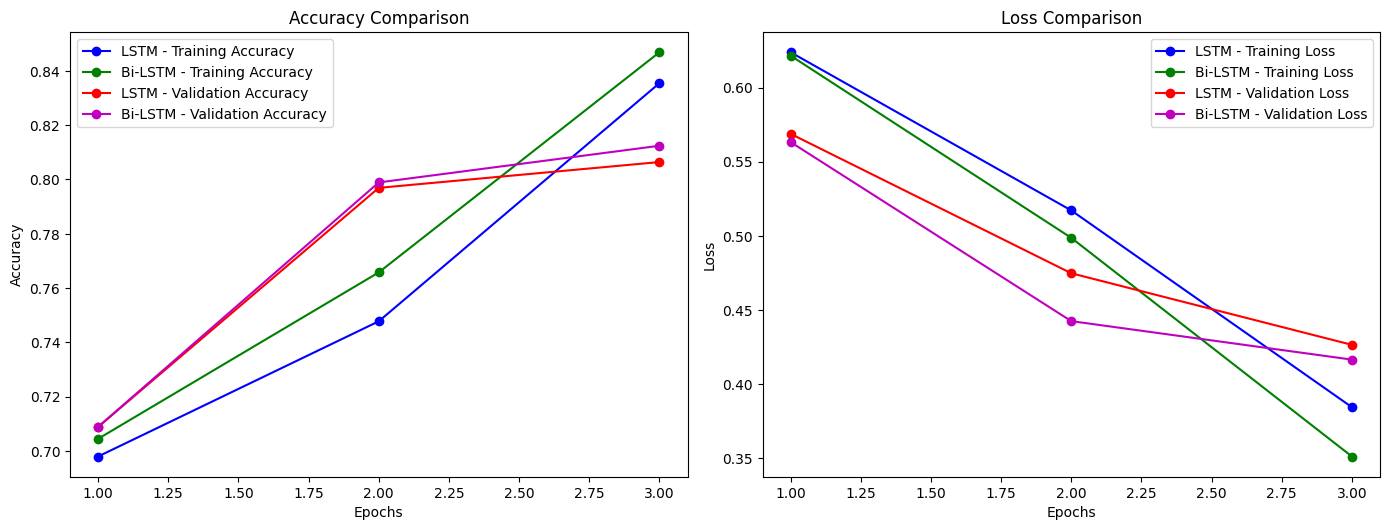

In [124]:
# Plot training and validation accuracy/loss for both models
def plot_comparison_history(history1, history2, model_name1, model_name2):
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']

    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    epochs1 = range(1, len(acc1) + 1)
    epochs2 = range(1, len(acc2) + 1)

    plt.figure(figsize=(14, 10))

    # Accuracy for both models
    plt.subplot(2, 2, 1)
    plt.plot(epochs1, acc1, 'bo-', label=f'{model_name1} - Training Accuracy')
    plt.plot(epochs2, acc2, 'go-', label=f'{model_name2} - Training Accuracy')
    plt.plot(epochs1, val_acc1, 'ro-', label=f'{model_name1} - Validation Accuracy')
    plt.plot(epochs2, val_acc2, 'mo-', label=f'{model_name2} - Validation Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss for both models
    plt.subplot(2, 2, 2)
    plt.plot(epochs1, loss1, 'bo-', label=f'{model_name1} - Training Loss')
    plt.plot(epochs2, loss2, 'go-', label=f'{model_name2} - Training Loss')
    plt.plot(epochs1, val_loss1, 'ro-', label=f'{model_name1} - Validation Loss')
    plt.plot(epochs2, val_loss2, 'mo-', label=f'{model_name2} - Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison_history(history1, history2, 'LSTM', 'Bi-LSTM')

In [125]:
# Summary table of two models
def summarize_model(history, model_name, test_accuracy):
    val_acc = history.history['val_accuracy']
    best_epoch = np.argmax(val_acc)

    return {
        'Model': model_name,
        'Final Training Accuracy': history.history['accuracy'][-1],
        'Final Validation Accuracy': val_acc[-1],
        'Test Accuracy': test_accuracy,
        'Final Training Loss': history.history['loss'][-1],
        'Final Validation Loss': history.history['val_loss'][-1],
        'Best Epoch': best_epoch + 1
    }

summary_lstm = summarize_model(history1, 'LSTM', test_accuracy1)
summary_bilstm = summarize_model(history2, 'Bi-LSTM', test_accuracy2)

# Combine summaries into a single DataFrame
summary_df = pd.DataFrame([summary_lstm, summary_bilstm])

# Display the table
print(summary_df.to_string(index=False))

  Model  Final Training Accuracy  Final Validation Accuracy  Test Accuracy  Final Training Loss  Final Validation Loss  Best Epoch
   LSTM                 0.835460                   0.806403      81.146803             0.384505               0.426537           3
Bi-LSTM                 0.846847                   0.812406      82.137496             0.351269               0.416574           3
